In [68]:
import warnings
import random
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from collections import OrderedDict

## Load Data

In [69]:
train_ds = np.loadtxt('../assets/training_dataset.txt', dtype=float)
test_ds = np.loadtxt('../assets/test_dataset.txt', dtype=float)

In [70]:
warnings.filterwarnings('ignore')
EPOCHS = 1000
hidden_neurons = 180

In [71]:
def data_extract(train_data):
    data_list = list()
    label_list = list()
    for val in train_data:
        data_list.append(val[0:784])
        label_list.append(int(val[784]))
    data_list = np.array(data_list)
    label_list = np.array(label_list)
    return data_list, label_list

np.random.shuffle(train_ds)

x_train, y_train = data_extract(train_ds)
x_test, y_test = data_extract(test_ds)
# x_train = x_train / 255

In [72]:
y_train

array([6, 7, 5, ..., 6, 1, 9])

# Neural Network class (Autoencoder)

In [73]:
class NeuralNetwork():
    
    def __init__(self, input_neuron: int, output_neurons: int, hidden_neurons: list, hidden_layers: int, learning_rate=0.01, momentum=0.5, epochs=EPOCHS, high=0.75, low=0.25):
        self.input_neuron = input_neuron
        self.output_neurons = output_neurons
        self.hidden_neurons = hidden_neurons
        self.hidden_layers = hidden_layers
        self.learning_rate = learning_rate
        self.momentum = momentum
        self.epochs = epochs
        self.high = high
        self.low = low
        self.b = 1
        self.y_hat = OrderedDict()
        self.w1 = np.random.randn(self.hidden_neurons[0], self.input_neuron) * np.sqrt(1 / (self.input_neuron + self.hidden_neurons[0]))
        if hidden_layers < 2:
            self.w2 = np.random.randn(self.output_neurons, self.hidden_neurons[0]) * np.sqrt(1 / (self.output_neurons + self.hidden_neurons[0]))
        else:
            self.w_dict = dict()
            for i in range(self.hidden_layers):
                temp = 'w' + str(i + 2)
                if self.hidden_layers - i == 1:
                    self.w_dict[temp] = np.random.rand(self.output_neurons, self.hidden_neurons[i]) * np.sqrt(1 / (self.output_neurons + self.hidden_neurons[i]))
                    break
                self.w_dict[temp] = np.random.rand(self.hidden_neurons[i + 1], self.hidden_neurons[i]) * np.sqrt(1 / (self.hidden_neurons[i + 1] + self.hidden_neurons[i]))
    
        
    def get_weight(self):
        if self.hidden_layers >= 2:
            return self.w1, self.w_dict
        return self.w1, self.w2
    
    
    def sigmoid(self, x): 
        return 1.0/(1.0 + np.exp(-x))


    def deri_sigmoid(self, x):
        return self.sigmoid(x) * (1 - self.sigmoid(x))

    
    def forward_prop(self, input_ds):
        self.z1 = np.dot(input_ds, self.w1.T) + self.b
        self.y_hat1 = self.sigmoid(self.z1)
        if self.hidden_layers < 2:
            self.z2 = np.dot(self.y_hat1, self.w2.T) + self.b # net input 
            self.y_hat2 = self.sigmoid(self.z2) # activation function for the output layer.
        else:
            self.z2 = np.dot(self.y_hat1, self.w_dict['w2'].T) + self.b # net input 
            self.y_hat['y_hat2'] = self.sigmoid(self.z2) # activation function for the output layer.
            for i in range(1, self.hidden_layers):
                temp_y = 'y_hat' + str(i + 1)
                temp_w = 'w' + str(i + 2)
                z = np.dot(self.y_hat[temp_y], self.w_dict[temp_w].T) + self.b
                temp_y = 'y_hat' + str(i + 2)
                self.y_hat[temp_y] = self.sigmoid(z)
                

    def get_output(self):
        if self.hidden_layers < 2:
            return self.y_hat2
        else:
            self.y_hat_val = list(self.y_hat.items())
            self.y_hat_value = np.array(list(self.y_hat_val[len(self.y_hat_val) - 1]))
            return np.asarray(self.y_hat_value[1])            
        
        
    def backward_prop(self, x, epochs):
          
        if self.hidden_layers < 2:
            self.threshold(self.y_hat2)
            self.output_errors = x - self.y_hat2
            
            self.d_output = self.output_errors * self.deri_sigmoid(self.y_hat2)
            # print(self.d_output.shape)
            # print(self.w2.shape)
            # print(self.y_hat1.shape)
            # temp = np.dot(self.d_output, self.w2)
            # print(temp.shape)
            self.d_hidden = self.deri_sigmoid(self.y_hat1) * np.dot(self.d_output, self.w2)
            # print(self.y_hat1.shape)
            delta_w_2 = self.learning_rate * np.dot(np.transpose(self.y_hat1), self.d_output) # Weights change  (hidden - output)            
            delta_w_1 = self.learning_rate * np.dot(np.transpose(x), self.d_hidden) # Weights change (input - hidden)

            
            if (epochs > 1): #run after epoch = 1 
                delta_w_2 += (self.momentum * self.pre_delta_w_2) 
                delta_w_1 += (self.momentum * self.pre_delta_w_1)
                self.w2 = self.w2 + delta_w_2.T # for (hidden - output)
                self.w1 = self.w1 + delta_w_1.T # for (input - output)
            
            self.pre_delta_w_2 = delta_w_2 # update of weights change
            self.pre_delta_w_1 = delta_w_1 # update of weights change
        
        else:
            w_key = ['w' + str(i + 2) for i in range(self.hidden_layers)]
            self.y_hat_val = list(self.y_hat.items())
            self.y_hat_value = np.array(list(self.y_hat_val[len(self.y_hat_val) - 1]))
            self.y_hat_val = np.array(list(self.y_hat_val))            
            self.threshold(self.y_hat_value[1])            
            self.output_errors = x - self.y_hat_value[1]
            index = len(self.y_hat_val) - 1
            
            while (index >= 0):
                self.d_output = self.output_errors * self.deri_sigmoid(self.y_hat_val[index][1])
                self.d_hidden = self.deri_sigmoid(self.y_hat_val[index - 1][1]) * np.dot(self.d_output, self.w_dict[w_key[index]])

                delta_w_2 = self.learning_rate * np.dot(np.transpose(self.y_hat_val[index - 1][1]), self.d_output) # Weights change (hidden - output)
                delta_w_1 = self.learning_rate * np.dot(np.transpose(x), self.d_hidden) # Weights change (input - hidden)

                if(epochs > 1): #run after epoch = 1 
                    delta_w_2 += (self.momentum * self.pre_delta_w_2)
                    delta_w_1 += (self.momentum * self.pre_delta_w_1)
                    self.w_dict[index] += delta_w_2.T # for (hidden - output)
                    self.w_dict[index] += delta_w_1.T # for (input - output)
                
                self.pre_delta_w_2 = delta_w_2 # update of weights change
                self.pre_delta_w_1 = delta_w_1 # update of weights change
                index -= 1
                self.threshold(self.y_hat_val[index-1][1])               
                self.output_errors = self.y_hat_val[index][1] - self.y_hat_val[index-1][1]
        
        
    def threshold(self, y_hat): #Set threshold for output values. Use during training.
        for q in y_hat:
            for idx, j in enumerate(q):
                if j >= self.high:
                    q[idx] = 1.0
                elif j <= self.low:
                    q[idx] = 0.0

# Train Autoencoder

In [74]:
def error_loss(y, yhat):
    ERRORS = 0
    for idx, x in enumerate(y):
        ERRORS += (0.5 * np.sum(((x - yhat[idx])**2)))
    return ERRORS / 784

In [75]:
nn = NeuralNetwork(784, 784, [hidden_neurons], 1)
nn.forward_prop(x_train)
training_errors = list()

In [76]:
nn.get_output().shape

(4000, 784)

In [77]:
for i in range(EPOCHS + 1):
    nn.forward_prop(x_train)
    if i % 10 == 0:
        print(f'Iteration {i}:')
        temp_output = error_loss(x_train, nn.get_output())
        training_errors.append(temp_output)
        print(f'Error fraction: {temp_output}')
    nn.backward_prop(x_train, i)

Iteration 0:
Error fraction: 917.2383392484554
Iteration 10:
Error fraction: 300.84051831694654
Iteration 20:
Error fraction: 298.71350061148195
Iteration 30:
Error fraction: 346.4651632226141
Iteration 40:
Error fraction: 320.17324952083663
Iteration 50:
Error fraction: 242.0694473300877
Iteration 60:
Error fraction: 168.89486465857811
Iteration 70:
Error fraction: 153.39662020723114
Iteration 80:
Error fraction: 127.74953830121487
Iteration 90:
Error fraction: 121.18010793442075
Iteration 100:
Error fraction: 116.19943117938942
Iteration 110:
Error fraction: 105.45791679721252
Iteration 120:
Error fraction: 100.20570253806386
Iteration 130:
Error fraction: 105.0727036158263
Iteration 140:
Error fraction: 105.1793415522922
Iteration 150:
Error fraction: 102.64080751764851
Iteration 160:
Error fraction: 108.17823414222268
Iteration 170:
Error fraction: 101.98278358458077
Iteration 180:
Error fraction: 95.44188939928122
Iteration 190:
Error fraction: 98.1308811061692
Iteration 200:
Erro

### Display for testing purpose

<AxesSubplot: >

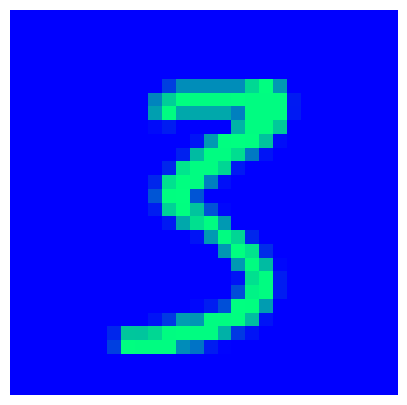

In [78]:
fig, ax = plt.subplots(1, 1, figsize=(5,5))
sns.heatmap(x_train[2399].reshape(28, 28).T, ax=ax, vmin=0, vmax=1, cmap='winter', xticklabels=False, yticklabels=False, cbar=False)

<AxesSubplot: >

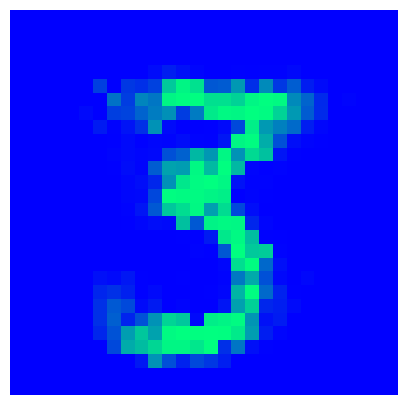

In [79]:
nn.forward_prop(x_train)
fig, ax = plt.subplots(1, 1, figsize=(5,5))
sns.heatmap(nn.get_output()[2399].reshape(28, 28).T, ax=ax, vmin=0, vmax=1, cmap='winter', xticklabels=False, yticklabels=False, cbar=False)

# Sample Output

In [80]:
def get_random_list(limit, num):
    random_list = list()
    iteration = 0
    while iteration < limit:
        r = random.randint(0, num - 1)
        if r not in random_list:
            random_list.append(r)
            iteration += 1
    return random_list


def get_index_digit(digit, data):
    index = list()
    for i, value in enumerate(data):
        if value == digit:
            index.append(i)
    return index


def get_error_digit(y, yhat, digits):
    ERRORS = 0
    for digit in digits:
        ERRORS += (0.5 * np.sum(((y[digit] - yhat[digit])**2)))                      
    return ERRORS / 784

In [81]:
random_sample = get_random_list(8, hidden_neurons)
print(random_sample)

[160, 166, 154, 148, 170, 144, 21, 79]


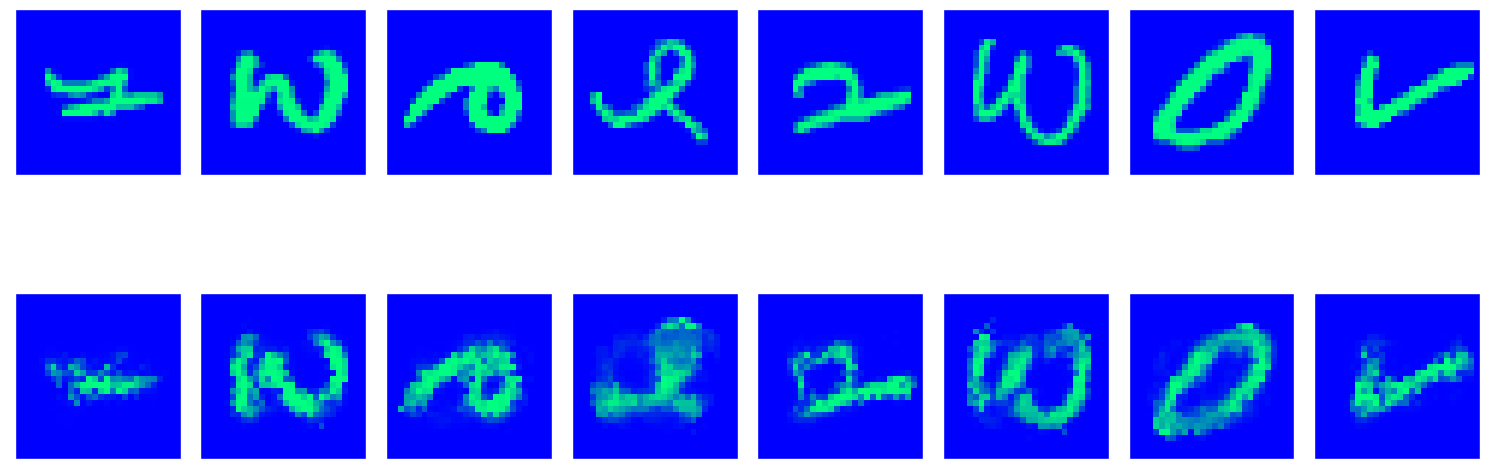

In [82]:
nn.forward_prop(x_test)
output_test = nn.get_output()
fig, ax = plt.subplots(2, 8, figsize=(15, 7))
plt.style.use('ggplot')
for i in range(len(random_sample)):
    ax[0, i].imshow(x_test[random_sample[i]].reshape(28, 28), cmap='winter')
    ax[1, i].imshow(output_test[random_sample[i]].reshape(28, 28), cmap='winter')
    ax[0, i].set_xticks([])
    ax[0, i].set_yticks([])
    ax[1, i].set_xticks([])
    ax[1, i].set_yticks([])
   
fig.tight_layout()

# Features

In [83]:
nn_weight = np.loadtxt('../assets/weight_jk_nn.txt', dtype=float)
print(nn_weight.shape)
nn.forward_prop(x_train)
w1, w2 = nn.get_weight()
print(w1.shape)

(180, 784)
(180, 784)


In [84]:
w1

array([[ 0.01498346,  0.02825543, -0.02772107, ..., -0.01399551,
         0.03737888,  0.02246765],
       [-0.02659916, -0.05164474,  0.00948531, ..., -0.00273698,
        -0.00285797, -0.01405831],
       [-0.00032485, -0.03033443, -0.01105956, ...,  0.03867819,
         0.07034347, -0.01149776],
       ...,
       [ 0.0778553 ,  0.02373461, -0.01471255, ..., -0.0141928 ,
        -0.01008181, -0.02701125],
       [-0.01619504, -0.03112617,  0.00696215, ...,  0.03012104,
        -0.015376  , -0.0355121 ],
       [ 0.01718753,  0.00489622, -0.04299055, ...,  0.03458942,
         0.06632763, -0.0239267 ]])

In [85]:
train_sample = get_random_list(20, hidden_neurons)
print(train_sample)

[173, 130, 129, 90, 13, 18, 80, 168, 45, 9, 11, 118, 22, 116, 84, 100, 15, 29, 57, 74]


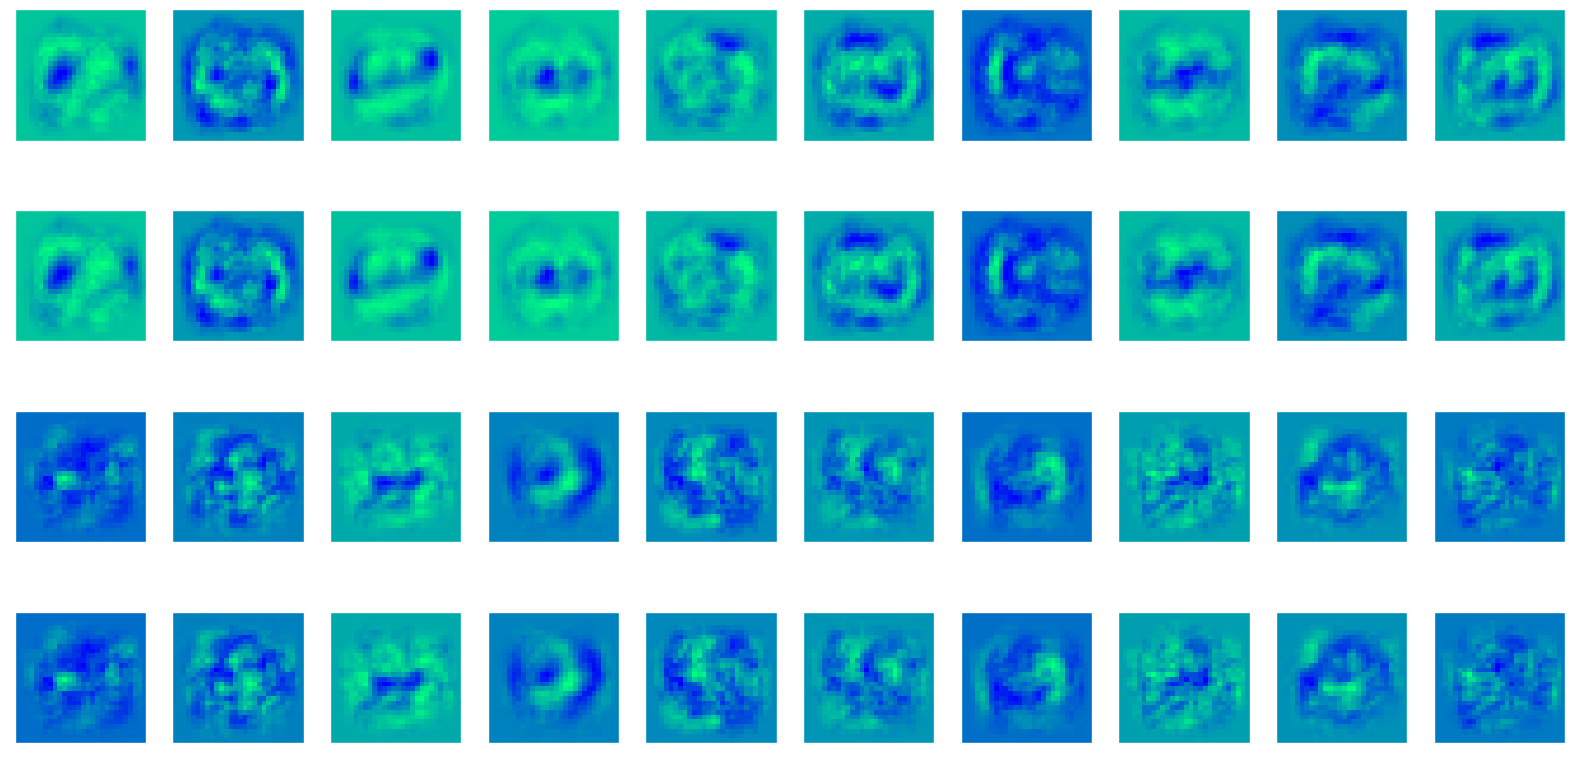

In [86]:
fig, ax = plt.subplots(4, 10, figsize=(20, 10))

for i in range(2):
    for j in range(10):
        ax[i, j].imshow(w1[train_sample[j]].reshape(28, 28), cmap='winter')
        ax[i, j].set_xticks([])
        ax[i, j].set_yticks([])
        ax[i + 2, j].imshow(nn_weight[train_sample[j]].reshape(28, 28), cmap='winter')
        ax[i + 2, j].set_xticks([])
        ax[i + 2, j].set_yticks([])
    # ax[i].set_title(f'neural_network weight', fontstyle='italic', fontsize=15)

# Result

## Bar Chart of average loss on every digit

In [87]:
def digit_extract(data):
    digits = dict()
    for i in range(10):
        digits[i] = get_index_digit(i, data)
    return digits

In [88]:
train_digits, test_digits = digit_extract(y_train), digit_extract(y_test)

In [90]:
nn.forward_prop(x_train)
train_output = nn.get_output()
nn.forward_prop(x_test)
test_output = nn.get_output()

In [91]:
def get_dataset_error(x, x_out, digits):
    errors = dict()
    for i in range(10):
        errors[i] = get_error_digit(x, x_out, digits[i])
    return errors

In [92]:
ERROR_TRAIN, ERROR_TEST = get_dataset_error(x_train, train_output, train_digits), get_dataset_error(x_test, test_output, test_digits)

In [93]:
ERROR_TRAIN

{0: 5.8946405528107055,
 1: 2.7676852883641136,
 2: 6.987498785283318,
 3: 6.031565867614295,
 4: 5.580912727424084,
 5: 6.57468429369516,
 6: 6.377258372932472,
 7: 5.6582643403646475,
 8: 7.35545021133302,
 9: 5.34846529121196}

Text(0.5, 1.0, 'Error for Training and Testing Set Per Number')

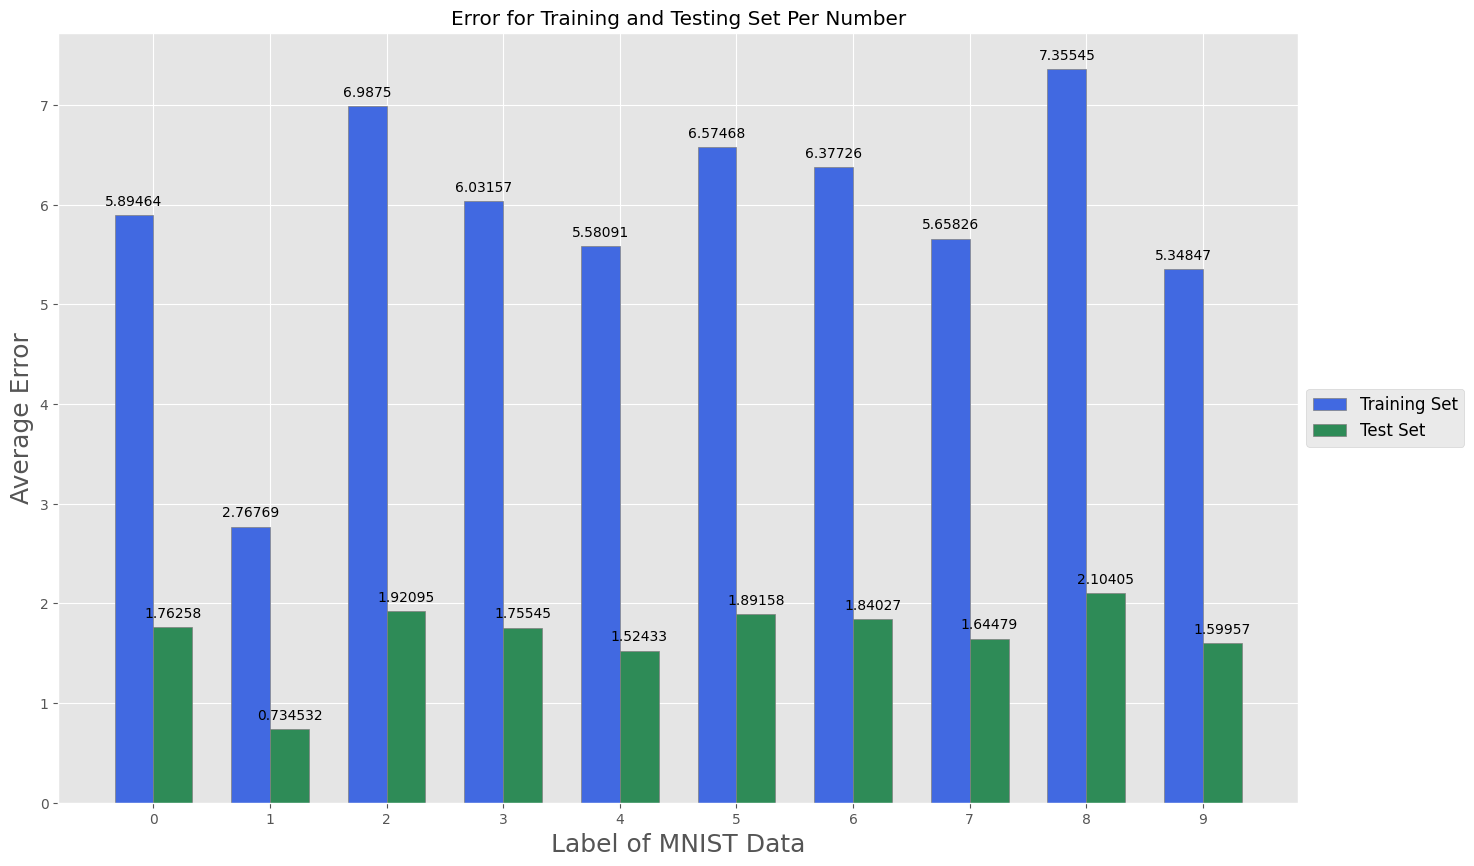

In [94]:
train_set = tuple(ERROR_TRAIN.values())
test_set = tuple(ERROR_TEST.values())
index = list(ERROR_TEST.keys())

width = np.min(np.diff(index)) / 3

fig = plt.figure(figsize=(20, 10))
ax = fig.add_subplot(111)
labels = [f'{i}' for i in range(10)]

rect1 = ax.bar(index - width, train_set, width=width, color='royalblue',label='Training Set', align='edge', edgecolor ='grey')
rect2 = ax.bar(index, test_set, width=width, color='seagreen',label='Test Set', align='edge',edgecolor ='grey')
ax.set_xticks(index, labels)
ax.bar_label(rect1, padding=5)
ax.bar_label(rect2, padding=5)
box = ax.get_position()
ax.set_position([box.x0, box.y0, box.width * 0.8, box.height])
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5), prop={'size': 12})
plt.xlabel('Label of MNIST Data', fontsize=18)
plt.ylabel('Average Error', fontsize=18)
plt.title('Error for Training and Testing Set Per Number')

## Time series of training error

Text(0, 0.5, 'Error rate')

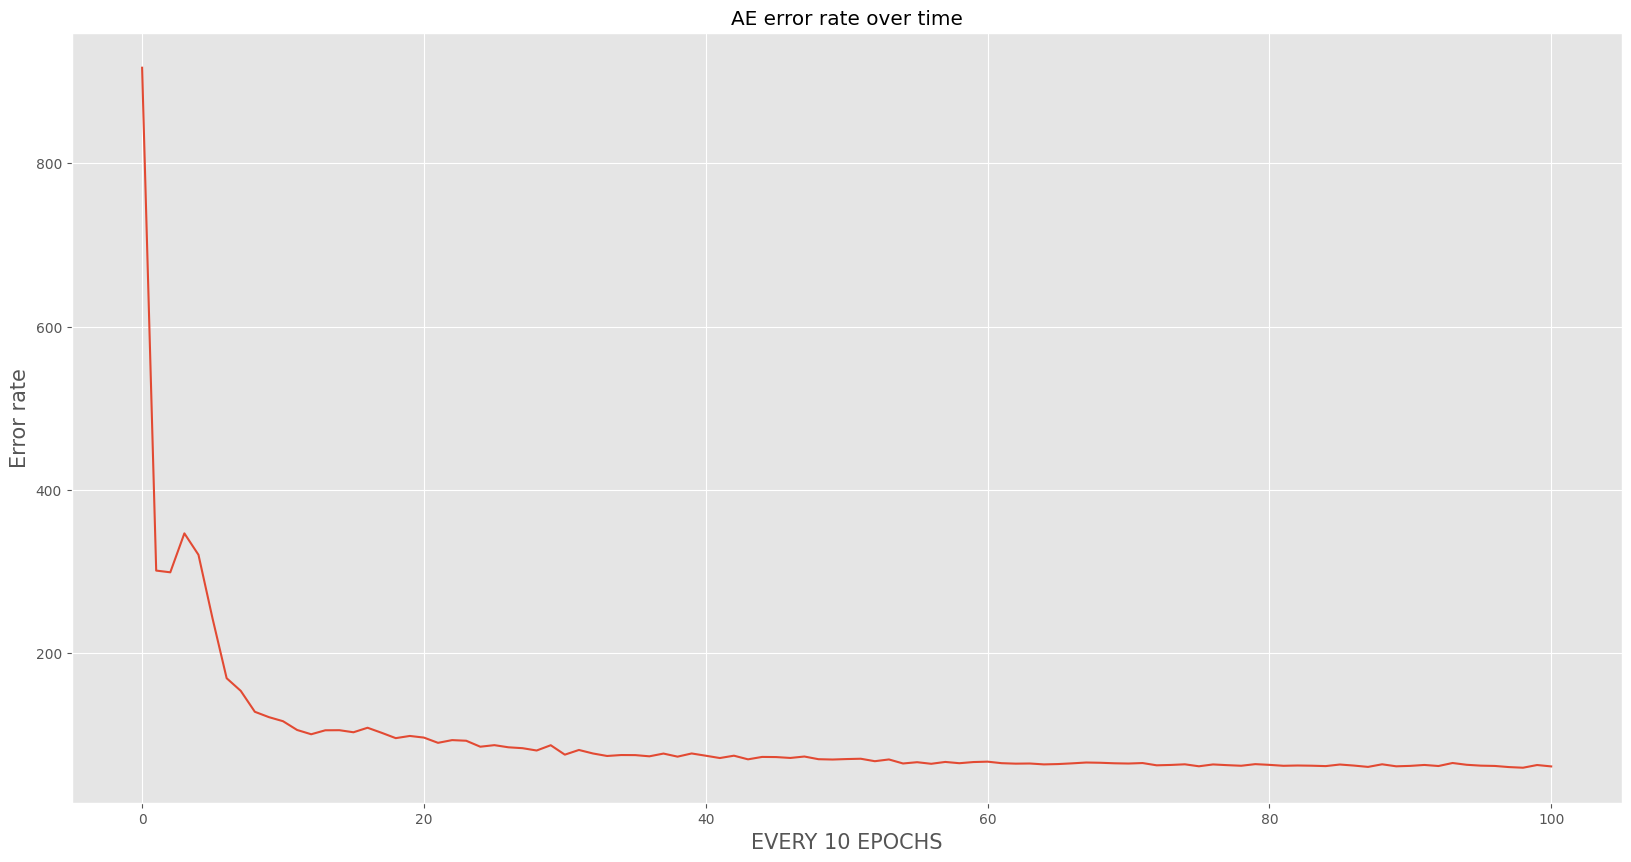

In [99]:
# Time series of error rate overtime
fig = plt.figure(figsize=(20, 10))
plt.plot(training_errors)
plt.title('AE error rate over time')
plt.xlabel('EVERY 10 EPOCHS', fontsize=15)
plt.ylabel('Error rate', fontsize=15)